## 1. **Configure the Notebook:** 

In [1]:
# Import necessary libraries
import numpy as np
from xarray_healpy import HealpyGridInfo, HealpyRegridder
from pangeo_fish.grid import center_longitude
import xarray as xr
import pandas as pd
import xdggs
from pangeo_fish.hmm.estimator import EagerEstimator
from pangeo_fish.hmm.optimize import EagerBoundsSearch
from pangeo_fish.utils import temporal_resolution
from pangeo_fish.hmm.prediction import Gaussian1DHealpix,Gaussian2DCartesian
from tlz.functoolz import curry
from pint_xarray import unit_registry as ureg

# earth_radius defines the radius of the Earth used for distance calculations.
earth_radius = ureg.Quantity(6371, "km")
# maximum_speed sets the maximum allowable speed for the tagged fish.
maximum_speed = ureg.Quantity(60, "km / day")

# It will factor the allowed maximum displacement of the fish.
adjustment_factor = 5
# truncate sets the truncating factor for computed maximum allowed sigma for convolution process.
truncate = 4
tolerance = 1e-6
# Defines default chunk size for optimisation.
chunk_time = 24
default_chunk = {"time": chunk_time, "lat": -1, "lon": -1}
default_chunk_xy = {"time": chunk_time, "x": -1, "y": -1}
default_chunk_cells = {"time": chunk_time, "cells": -1}

/home/ecap/micromamba/envs/pangeo-fish/lib/python3.11/site-packages/movingpandas/__init__.py:37: UserWarning: Missing optional dependencies. To use the trajectory smoother classes please install Stone Soup (see https://stonesoup.readthedocs.io/en/latest/#installation).
  warnings.warn(e.msg, UserWarning)


In [2]:
import xarray as xr
emission = xr.open_dataset('../A19124/combined.zarr',
                           engine="zarr",
                           chunks={},
                           inline_array=True,
                           storage_options=None,
                        )
emission

<xarray.Dataset> Size: 409MB
Dimensions:     (y: 294, x: 659, time: 258)
Coordinates:
    cell_ids    (y, x) int64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    latitude    (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    longitude   (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    resolution  float64 8B ...
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: y, x
Data variables:
    final       (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    initial     (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    mask        (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    pdf         (time, x, y) float64 400MB dask.array<chunksize=(24, 659, 294), meta=np.ndarray>
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0

In [3]:
def sigma_to_radian(sigma, earth_radius_km=6371):
    """
    Convert sigma (arc length) to radians.
    
    Parameters:
    - sigma: float, the arc length in the same unit as earth_radius_km.
    - earth_radius_km: float, the Earth's radius in kilometers (default: 6371 km).
    
    Returns:
    - float: sigma in radians.
    """
    return sigma / earth_radius_km

# Apply the function to sigma = 1.06
sigma = 1.06
sigma_radian = sigma_to_radian(sigma)

print(f"Sigma in radians: {sigma_radian}")
earth_radius_ = xr.DataArray(earth_radius, dims=None)

timedelta = temporal_resolution(emission["time"]).pint.quantify().pint.to("h")
grid_resolution = earth_radius_ * emission["resolution"].pint.quantify()

maximum_speed_ = xr.DataArray(maximum_speed, dims=None).pint.to("km / h")
max_grid_displacement = maximum_speed_ * timedelta * adjustment_factor / grid_resolution
max_sigma = max_grid_displacement.pint.to("dimensionless").pint.magnitude / truncate

max_grid_displacement_radian = maximum_speed_ * timedelta * adjustment_factor / earth_radius_
max_sigma_radian = max_grid_displacement_radian.pint.to("dimensionless").pint.magnitude / truncate

# Applying max sigma over the emission matrices
emission.attrs["max_sigma"] = max_sigma_radian.item()
print(max_sigma.item())

print(max_sigma_radian)
emission

Sigma in radians: 0.0001663789044106106
1.963306279189256
0.0004905038455501491


/home/ecap/pangeo-fish/pangeo_fish/utils.py:122: FutureWarning: Hour.delta is deprecated and will be removed in a future version. Use pd.Timedelta(obj) instead
  timedelta = to_offset(freq).delta.to_numpy()


<xarray.Dataset> Size: 409MB
Dimensions:     (y: 294, x: 659, time: 258)
Coordinates:
    cell_ids    (y, x) int64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    latitude    (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    longitude   (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    resolution  float64 8B ...
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: y, x
Data variables:
    final       (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    initial     (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    mask        (y, x) float64 2MB dask.array<chunksize=(294, 659), meta=np.ndarray>
    pdf         (time, x, y) float64 400MB dask.array<chunksize=(24, 659, 294), meta=np.ndarray>
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0
    max_sigma:  0.0004905038455501491

In [4]:
emission = emission.stack(cells=("y", "x"))
emission = emission.drop_vars(['x','y'])
# Set required attributes cleanly
emission["cell_ids"].attrs["grid_name"] = "healpix"
#emission_1D["cell_ids"].attrs["nest"] = True
# Récupérer les attributs existants de cell_ids
attrs_to_keep = ["level", "grid_name"]
# should also have nest
emission["cell_ids"].attrs = {key: value for key, value in emission["cell_ids"].
                              attrs.items() if key in attrs_to_keep}
emission

/tmp/ipykernel_16298/299093097.py:2: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'cells'} to avoid an error in the future.
  emission = emission.drop_vars(['x','y'])


<xarray.Dataset> Size: 409MB
Dimensions:     (cells: 193746, time: 258)
Coordinates:
    cell_ids    (cells) int64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    latitude    (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    longitude   (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    resolution  float64 8B ...
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: cells
Data variables:
    final       (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    initial     (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    mask        (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    pdf         (time, cells) float64 400MB dask.array<chunksize=(24, 193746), meta=np.ndarray>
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0
    max_sigma:  0.0004905038455501491

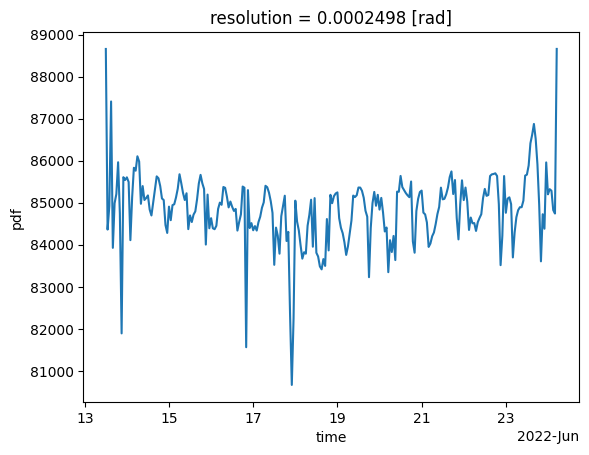

In [5]:

emission['pdf'].count(dim='cells').plot()

In [6]:
#emission_regridded_plus = emission_regridded_plus.compute()  # WHAT DOES IT CHANGE?
emission_1D = emission.assign_coords({'cell_ids':lambda ds:ds['cell_ids'].compute()}).sortby('cell_ids').pipe(xdggs.decode)
predictor_factory = curry(
    Gaussian1DHealpix,
    cell_ids=emission_1D["cell_ids"].data,
    grid_info=emission_1D.dggs.grid_info,
    truncate=4.0,
    weights_threshold=1e-8,
    pad_kwargs={"mode": "constant", "constant_value": 0},
    optimize_convolution=True,
)
emission_1D

<xarray.Dataset> Size: 409MB
Dimensions:     (cells: 193746, time: 258)
Coordinates:
  * cell_ids    (cells) int64 2MB 55996335 55996346 ... 58020672 58020674
    latitude    (cells) float64 2MB 42.45 42.46 42.47 ... 54.06 54.06 54.08
    longitude   (cells) float64 2MB -7.398 -7.378 -7.357 ... -1.149 -1.149
    resolution  float64 8B 0.0002498
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: cells
Data variables:
    final       (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    initial     (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    mask        (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    pdf         (time, cells) float64 400MB dask.array<chunksize=(24, 193746), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(nside=12, indexing_scheme=nested)
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0
    max_sigma:  0.0004905038455501491

In [8]:
##############################
# MANUELLEMENT AJOUT DU SIGMA
#############################
optimized = EagerEstimator(
            sigma=0.0001663789044106106,
            predictor_factory=predictor_factory)

optimized

EagerEstimator(predictor_factory=<class 'pangeo_fish.hmm.prediction.Gaussian1DHealpix'>, sigma=0.0001663789044106106, predictor=None)

In [9]:
emission_1D = emission_1D.compute()

In [10]:
predictor = predictor_factory(sigma=optimized.sigma)
data = predictor.predict(emission_1D.initial.data,mask=emission_1D.mask.data)
emission_1D.initial.copy(data=data).dggs.explore(alpha=0.8)


Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro3.core.ChunkedArray<Fixed…

In [11]:
emission_1D = emission_1D.compute()

In [12]:
emission_1D

<xarray.Dataset> Size: 409MB
Dimensions:     (cells: 193746, time: 258)
Coordinates:
  * cell_ids    (cells) int64 2MB 55996335 55996346 ... 58020672 58020674
    latitude    (cells) float64 2MB 42.45 42.46 42.47 ... 54.06 54.06 54.08
    longitude   (cells) float64 2MB -7.398 -7.378 -7.357 ... -1.149 -1.149
    resolution  float64 8B 0.0002498
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: cells
Data variables:
    final       (cells) float64 2MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    initial     (cells) float64 2MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mask        (cells) float64 2MB nan nan nan nan nan ... nan nan nan nan nan
    pdf         (time, cells) float64 400MB nan nan nan nan ... nan nan nan nan
Indexes:
    cell_ids  HealpixIndex(nside=12, indexing_scheme=nested)
Attributes:
    grid_type:  healpix
    lat:        0
    level:      12
    lon:        0
    nside:      4096
    rot_lat:    0
    rot_lon:    0
    max_sigma:  0.0004905038455501491

In [13]:
emission_1D.initial.sum('cells')

<xarray.DataArray 'initial' ()> Size: 8B
array(1.)
Coordinates:
    resolution  float64 8B 0.0002498

In [14]:
import healpy as hp

hp.max_pixrad(emission_1D.dggs.grid_info.nside, degrees=False)

np.float64(0.0002609666412327938)

In [15]:
hp.nside2resol(emission_1D.dggs.grid_info.nside,arcmin=False)

np.float64(0.00024983562205724817)

In [16]:
states_1D = optimized.predict_proba(emission_1D)
states_1D = states_1D.to_dataset().chunk(default_chunk_cells).persist()
states_1D

<xarray.Dataset> Size: 405MB
Dimensions:     (cells: 193746, time: 258)
Coordinates:
  * cell_ids    (cells) int64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    latitude    (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    longitude   (cells) float64 2MB dask.array<chunksize=(193746,), meta=np.ndarray>
    resolution  float64 8B 0.0002498
  * time        (time) datetime64[ns] 2kB 2022-06-13T12:00:00 ... 2022-06-24T...
Dimensions without coordinates: cells
Data variables:
    states      (time, cells) float64 400MB dask.array<chunksize=(24, 193746), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(nside=12, indexing_scheme=nested)

In [17]:
# Vérifier si des valeurs non-NaN existent dans la variable 'pdf'
non_nan_mask = states_1D["states"].notnull()

# Optionnellement, compter le nombre de valeurs non-NaN
non_nan_count = non_nan_mask.sum()
print(f"Nombre de valeurs non-NaN dans 'states': {non_nan_count.values}")


Nombre de valeurs non-NaN dans 'states': 2946087


In [18]:
states_1D.pipe(xdggs.decode).isel(time=1).compute().states.dggs.explore(alpha=0.8)

Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro3.core.ChunkedArray<Fixed…

In [19]:
emission_1D.pipe(xdggs.decode).isel(time=-1).compute().pdf.where(lambda x:x>0).dggs.explore(alpha=0.8)

Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro3.core.ChunkedArray<Fixed…

In [20]:
predictor = predictor_factory(sigma=optimized.sigma)
data = predictor.predict(emission_1D.pdf.isel(time=1).data,mask=emission_1D.mask.data)
emission_1D.initial.copy(data=data).dggs.explore(alpha=0.8)
#predictor

Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro3.core.ChunkedArray<Fixed…

In [21]:
states_1D.to_zarr(
    f"states_healpix_1D.zarr",
    mode="w",
    consolidated=True,
    storage_options=None,
)